In [25]:
## LIBRARIES
import matplotlib.dates as mdates
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

pd.set_option('display.max_columns', None) # see all pd column

In [26]:
## FONCTIONS
def conv_month_letter(mois):
    ''' input : int between 1 and 12 
        output : str 3 letters of the month
    '''
    list_MONTH = ["Jan","Fev","Mar","Avr","Mai","Jui","Jul","Aou","Sept","Oct","Nov","Dec"]
    return(list_MONTH[int(mois)-1])

In [27]:
## Input/Output
DATA_FOLDER = "C:\\Users\\E2884\\Desktop\\WPy64-3980\\notebooks\\data\\EXAQUANTUM\\BDD_DISPO\\"
FILE = "202308_SCL_DISPO_U1.xlsx"

YEAR = FILE[2:4]
MONTH = conv_month_letter(FILE[4:6])
TRANCHE = FILE[-7:-5]

In [28]:
## Import "TAGS" sheet from xls to pandas
df_TAGS = pd.read_excel(DATA_FOLDER + FILE, sheet_name='TAGS')
dict_TAGS = dict(zip(df_TAGS.TAGS, df_TAGS.DESIGNATION))

## Import raw data from xls to pandas
df_DATA = pd.read_excel(DATA_FOLDER + FILE, sheet_name='EXPORT')

In [29]:
## Renomage du label de chaque colonne
for designation_in in df_DATA.columns:
    df_DATA = df_DATA.rename(columns={designation_in: dict_TAGS[designation_in]})

In [30]:
## Mise en forme des columns
df_DATA.U1_PUISSANCE_MW = df_DATA.U1_PUISSANCE_MW.round(2)
df_DATA.U1_DEBIT_CHARBON_BR1_TH = df_DATA.U1_DEBIT_CHARBON_BR1_TH.round(2)
df_DATA.U1_DEBIT_CHARBON_BR2_TH = df_DATA.U1_DEBIT_CHARBON_BR2_TH.round(2)

In [31]:
PAS_MIN = 2

# HFO
df_DATA['U1_CONSO_HFO_TH']=df_DATA['U1_DEBIT_HFO_RP1_IN_TH']+df_DATA['U1_DEBIT_HFO_RP2_IN_TH']-df_DATA['U1_DEBIT_HFO_RP1_OUT_TH']-df_DATA['U1_DEBIT_HFO_RP2_OUT_TH']
df_DATA['U1_CONSO_HFO_TH']=df_DATA['U1_CONSO_HFO_TH'].round(2)
conditions = [(df_DATA['U1_CONSO_HFO_TH'] >= 0),(df_DATA['U1_CONSO_HFO_TH'] < 0),]
values = [df_DATA['U1_CONSO_HFO_TH'],0]
df_DATA['U1_CONSO_HFO_TH'] = np.select(conditions, values)

# ENERGIE
df_DATA['U1_ENERGIE_MWH'] = df_DATA['U1_PUISSANCE_MW']*1000000*PAS_MIN*60/3600000000
df_DATA['U1_ENERGIE_MWH_CUM'] = df_DATA['U1_ENERGIE_MWH'].cumsum().round(2)

# CHARBON
df_DATA['U1_CONSO_COAL_BR1_T'] = df_DATA['U1_DEBIT_CHARBON_BR1_TH']/60*PAS_MIN
df_DATA['U1_CONSO_COAL_BR2_T'] = df_DATA['U1_DEBIT_CHARBON_BR2_TH']/60*PAS_MIN

df_DATA['U1_CONSO_COAL_BR1_T_CUM'] = df_DATA['U1_CONSO_CHARBON_BR1_T'] - df_DATA['U1_CONSO_CHARBON_BR1_T'].iloc[0]
df_DATA['U1_CONSO_COAL_BR2_T_CUM'] = df_DATA['U1_CONSO_CHARBON_BR2_T'] - df_DATA['U1_CONSO_CHARBON_BR2_T'].iloc[0]
df_DATA['U1_CONSO_COAL_T_CUM'] = df_DATA['U1_CONSO_COAL_BR1_T_CUM'] + df_DATA['U1_CONSO_COAL_BR2_T_CUM']


df_DATA['U1_HFO_T'] = df_DATA['U1_CONSO_HFO_TH']/60*PAS_MIN
df_DATA['U1_HFO_T_CUM'] = df_DATA['U1_HFO_T'].cumsum()


SEUIL_FONCT_BR = 1
SEUIL_FONCT_HFO = 2

# Ajout colonne BR1 BOOL
conditions = [(df_DATA['U1_DEBIT_CHARBON_BR1_TH'] >= SEUIL_FONCT_BR),(df_DATA['U1_DEBIT_CHARBON_BR1_TH'] < SEUIL_FONCT_BR),]
values = [0.5,0]
df_DATA['U1_BOOL_BR1'] = np.select(conditions, values)

# Ajout colonne BR2 BOOL
conditions = [(df_DATA['U1_DEBIT_CHARBON_BR2_TH'] >= SEUIL_FONCT_BR),(df_DATA['U1_DEBIT_CHARBON_BR2_TH'] < SEUIL_FONCT_BR),]
values = [1.1,0.6]
df_DATA['U1_BOOL_BR2'] = np.select(conditions, values)

# Ajout colonne BR BOOL
conditions = [
    (df_DATA['U1_DEBIT_CHARBON_BR1_TH'] >= SEUIL_FONCT_BR) & (df_DATA['U1_DEBIT_CHARBON_BR2_TH'] >= SEUIL_FONCT_BR),
    (df_DATA['U1_DEBIT_CHARBON_BR1_TH'] < SEUIL_FONCT_BR) & (df_DATA['U1_DEBIT_CHARBON_BR2_TH'] < SEUIL_FONCT_BR),
    (df_DATA['U1_DEBIT_CHARBON_BR2_TH'] < SEUIL_FONCT_BR),
    (df_DATA['U1_DEBIT_CHARBON_BR1_TH'] < SEUIL_FONCT_BR),
]
values = [2,0,1,1]
df_DATA['U1_BOOL_BR'] = np.select(conditions, values)

# Ajout colonne HFO BOOL
conditions = [(df_DATA['U1_CONSO_HFO_TH'] >= SEUIL_FONCT_HFO),(df_DATA['U1_CONSO_HFO_TH'] < SEUIL_FONCT_HFO),]
values = [1.7,1.2]
df_DATA['U1_BOOL_HFO'] = np.select(conditions, values)


# 1 KWH = 3,6 MJ = 860 kcal
CS_COAL_KJKG = 27000
CS_HFO_KJKG = 41000
CS_COAL_MWHT = CS_COAL_KJKG/3600000*1000
CS_HFO_MWHT = CS_HFO_KJKG/3600000*1000 #KJ/KG

# Energie thermique produite
df_DATA['U1_BR1_COAL_MWHT'] = df_DATA['U1_CONSO_COAL_BR1_T']*CS_COAL_MWHT
df_DATA['U1_BR2_COAL_MWHT'] = df_DATA['U1_CONSO_COAL_BR2_T']*CS_COAL_MWHT
df_DATA['U1_BR_COAL_MWHT'] = df_DATA['U1_BR1_COAL_MWHT'] + df_DATA['U1_BR2_COAL_MWHT']

df_DATA['U1_BR1_COAL_MWHT_CUM'] = df_DATA['U1_CONSO_COAL_BR1_T_CUM']*CS_COAL_MWHT
df_DATA['U1_BR2_COAL_MWHT_CUM'] = df_DATA['U1_CONSO_COAL_BR2_T_CUM']*CS_COAL_MWHT
df_DATA['U1_BR_COAL_MWHT_CUM'] = df_DATA['U1_BR1_COAL_MWHT_CUM'] + df_DATA['U1_BR2_COAL_MWHT_CUM']

df_DATA['U1_HFO_COAL_MWHT'] = df_DATA['U1_HFO_T']*CS_HFO_MWHT
df_DATA['U1_HFO_COAL_MWHT_CUM'] = df_DATA['U1_HFO_T_CUM']*CS_HFO_MWHT

df_DATA['U1_FUEL_MWHT'] = df_DATA['U1_BR_COAL_MWHT'] + df_DATA['U1_HFO_COAL_MWHT']
df_DATA['U1_FUEL_MWHT_CUM'] = df_DATA['U1_BR_COAL_MWHT_CUM'] + df_DATA['U1_HFO_COAL_MWHT_CUM']

df_DATA['U1_BR1_COAL_MWHT_PCT'] = df_DATA['U1_BR1_COAL_MWHT']/df_DATA['U1_FUEL_MWHT']
df_DATA['U1_BR2_COAL_MWHT_PCT'] = df_DATA['U1_BR2_COAL_MWHT']/df_DATA['U1_FUEL_MWHT']
df_DATA['U1_HFO_COAL_MWHT_PCT'] = df_DATA['U1_HFO_COAL_MWHT']/df_DATA['U1_FUEL_MWHT']

df_DATA['U1_RENDEMENT'] = df_DATA['U1_ENERGIE_MWH']/df_DATA['U1_FUEL_MWHT']

# CS KJ/KWH

df_DATA['U1_CS'] = (((df_DATA['U1_CONSO_COAL_BR1_T']+df_DATA['U1_CONSO_COAL_BR2_T'])*1000*CS_COAL_KJKG + df_DATA['U1_HFO_T']*1000*CS_HFO_KJKG)/(df_DATA['U1_ENERGIE_MWH']*1000)).round(2)

for col in df_DATA.columns:
    print(col)

U9_TIME
U1_PUISSANCE_MW
U1_DEBIT_CHARBON_BR1_TH
U1_DEBIT_CHARBON_BR2_TH
U1_CONSO_CHARBON_BR1_T
U1_CONSO_CHARBON_BR2_T
U1_DEBIT_HFO_RP1_IN_TH
U1_DEBIT_HFO_RP1_OUT_TH
U1_DEBIT_HFO_RP2_IN_TH
U1_DEBIT_HFO_RP2_OUT_TH
U1_CONSO_HFO_TH
U1_ENERGIE_MWH
U1_ENERGIE_MWH_CUM
U1_CONSO_COAL_BR1_T
U1_CONSO_COAL_BR2_T
U1_CONSO_COAL_BR1_T_CUM
U1_CONSO_COAL_BR2_T_CUM
U1_CONSO_COAL_T_CUM
U1_HFO_T
U1_HFO_T_CUM
U1_BOOL_BR1
U1_BOOL_BR2
U1_BOOL_BR
U1_BOOL_HFO
U1_BR1_COAL_MWHT
U1_BR2_COAL_MWHT
U1_BR_COAL_MWHT
U1_BR1_COAL_MWHT_CUM
U1_BR2_COAL_MWHT_CUM
U1_BR_COAL_MWHT_CUM
U1_HFO_COAL_MWHT
U1_HFO_COAL_MWHT_CUM
U1_FUEL_MWHT
U1_FUEL_MWHT_CUM
U1_BR1_COAL_MWHT_PCT
U1_BR2_COAL_MWHT_PCT
U1_HFO_COAL_MWHT_PCT
U1_RENDEMENT
U1_CS


In [32]:
## Define date as datetime type
df_DATA['U9_TIME']=pd.to_datetime(df_DATA['U9_TIME'],unit='s')

In [33]:
## Bilan indicateurs

INDICATEUR = "Nombre d'heure du mois (h)"
NOMBRE_HEURE_MOIS = round(len(df_DATA.index)*PAS_MIN/60,1)
print("{:<40} : {:<10}".format(INDICATEUR,NOMBRE_HEURE_MOIS))

INDICATEUR = "Nombre d'heure en production (h)"
NOMBRE_HEURE_PRODUCTION = round(df_DATA.U1_PUISSANCE_MW[df_DATA.U1_PUISSANCE_MW > 5].count()*PAS_MIN/60,1)
print("{:<40} : {:<10} {:<5}%".format(INDICATEUR,NOMBRE_HEURE_PRODUCTION, round((NOMBRE_HEURE_PRODUCTION/NOMBRE_HEURE_MOIS)*100,2)))

INDICATEUR = "Puissance moyenne mensuel (MW)"
PUISSANCE_MOY_MENSUEL = round(df_DATA['U1_PUISSANCE_MW'].mean(),2)
print("{:<40} : {:<10}".format(INDICATEUR,PUISSANCE_MOY_MENSUEL))

INDICATEUR = "Puissance moyenne en production (MW)"
PUISSANCE_MOY_PRODUCTION = round(df_DATA.U1_PUISSANCE_MW[df_DATA.U1_PUISSANCE_MW > 5].mean(),2)
print("{:<40} : {:<10}".format(INDICATEUR,PUISSANCE_MOY_PRODUCTION))

INDICATEUR = "Puissance max (MW)"
PUISSANCE_MAX = round(df_DATA['U1_PUISSANCE_MW'].max(),2)
print("{:<40} : {:<10}".format(INDICATEUR,PUISSANCE_MAX))

INDICATEUR = "Energie produite (MWh)"
ENERGIE_MWH = round(df_DATA['U1_ENERGIE_MWH'].sum(),2)
print("{:<40} : {:<10}".format(INDICATEUR,ENERGIE_MWH))

INDICATEUR = "Conso charbon BR1 (T)"
CONSO_CHARBON_BR1 = round(df_DATA['U1_CONSO_COAL_BR1_T_CUM'].iloc[-1],1)
print("{:<40} : {:<10}".format(INDICATEUR,CONSO_CHARBON_BR1))

INDICATEUR = "Conso charbon BR2 (T)"
CONSO_CHARBON_BR2 = round(df_DATA['U1_CONSO_COAL_BR2_T_CUM'].iloc[-1],1)
print("{:<40} : {:<10}".format(INDICATEUR,CONSO_CHARBON_BR2))

INDICATEUR = "Conso charbon totale (T)"
CONSO_CHARBON_U1 = round(df_DATA['U1_CONSO_COAL_T_CUM'].iloc[-1],1)
print("{:<40} : {:<10}".format(INDICATEUR,CONSO_CHARBON_U1))

INDICATEUR = "Nombre d'heure BR1 (h)"
NOMBRE_HEURE_BR1 = round(df_DATA.U1_DEBIT_CHARBON_BR1_TH[df_DATA.U1_DEBIT_CHARBON_BR1_TH > SEUIL_FONCT_BR].count()*PAS_MIN/60,1)
print("{:<40} : {:<10} {:<5}%".format(INDICATEUR,NOMBRE_HEURE_BR1, round((NOMBRE_HEURE_BR1/NOMBRE_HEURE_PRODUCTION)*100,2)))

INDICATEUR = "Nombre d'heure BR2 (h)"
NOMBRE_HEURE_BR2 = round(df_DATA.U1_DEBIT_CHARBON_BR2_TH[df_DATA.U1_DEBIT_CHARBON_BR2_TH > SEUIL_FONCT_BR].count()*PAS_MIN/60,1)
print("{:<40} : {:<10} {:<5}%".format(INDICATEUR,NOMBRE_HEURE_BR2, round((NOMBRE_HEURE_BR2/NOMBRE_HEURE_PRODUCTION)*100,2)))

INDICATEUR = "Nombre d'heure à deux BR (h)"
NOMBRE_HEURE_BR = round(df_DATA.U1_DEBIT_CHARBON_BR2_TH[df_DATA.U1_BOOL_BR == 2].count()*PAS_MIN/60,1)
print("{:<40} : {:<10} {:<5}%".format(INDICATEUR,NOMBRE_HEURE_BR, round((NOMBRE_HEURE_BR/NOMBRE_HEURE_PRODUCTION)*100,2)))

INDICATEUR = "Nombre d'heure à 1 BR (h)"
NOMBRE_HEURE_one_BR = round(df_DATA.U1_DEBIT_CHARBON_BR2_TH[df_DATA.U1_BOOL_BR == 1].count()*PAS_MIN/60,1)
print("{:<40} : {:<10} {:<5}%".format(INDICATEUR,NOMBRE_HEURE_one_BR, round((NOMBRE_HEURE_one_BR/NOMBRE_HEURE_PRODUCTION)*100,2)))


INDICATEUR = "Débit moyen HFO (t/h)"
DEBIT_MOY_HFO = round(df_DATA.U1_CONSO_HFO_TH[df_DATA.U1_CONSO_HFO_TH > SEUIL_FONCT_HFO].mean(),2)
print("{:<40} : {:<10}".format(INDICATEUR,DEBIT_MOY_HFO))

INDICATEUR = "Nombre d'heure HFO (h)"
NOMBRE_HEURE_HFO = round(df_DATA.U1_CONSO_HFO_TH[df_DATA.U1_CONSO_HFO_TH > SEUIL_FONCT_HFO].count()*PAS_MIN/60,1)
print("{:<40} : {:<10} {:<5}%".format(INDICATEUR,NOMBRE_HEURE_HFO, round((NOMBRE_HEURE_HFO/NOMBRE_HEURE_PRODUCTION)*100,2)))

INDICATEUR = "Conso HFO (T)"
CONSO_HFO = round(df_DATA['U1_HFO_T_CUM'].iloc[-1],1)
print("{:<40} : {:<10}".format(INDICATEUR,CONSO_HFO))

df_tmp = df_DATA.loc[df_DATA['U1_PUISSANCE_MW'] >= 5]
INDICATEUR = "Rendement moyen mensuel"
RENDEMENT_MOY = round(df_tmp['U1_RENDEMENT'].mean(),3)
print("{:<40} : {:<10}".format(INDICATEUR,RENDEMENT_MOY))

df_tmp1 = df_DATA.loc[df_DATA['U1_PUISSANCE_MW'] >= 5]
INDICATEUR = "CS moyenne mensuelle (KJ/KWh)"
CS_MOY = round(df_tmp['U1_CS'].mean(),1)
print("{:<40} : {:<10}".format(INDICATEUR,CS_MOY))

Nombre d'heure du mois (h)               : 744.0     
Nombre d'heure en production (h)         : 744.0      100.0%
Puissance moyenne mensuel (MW)           : 41.53     
Puissance moyenne en production (MW)     : 41.53     
Puissance max (MW)                       : 52.56     
Energie produite (MWh)                   : 30897.79  
Conso charbon BR1 (T)                    : 5888.6    
Conso charbon BR2 (T)                    : 5669.5    
Conso charbon totale (T)                 : 11558.0   
Nombre d'heure BR1 (h)                   : 719.9      96.76%
Nombre d'heure BR2 (h)                   : 698.8      93.92%
Nombre d'heure à deux BR (h)             : 674.7      90.69%
Nombre d'heure à 1 BR (h)                : 69.3       9.31 %
Débit moyen HFO (t/h)                    : 3.61      
Nombre d'heure HFO (h)                   : 66.8       8.98 %
Conso HFO (T)                            : 336.1     
Rendement moyen mensuel                  : 0.341     
CS moyenne mensuelle (KJ/KWh)           

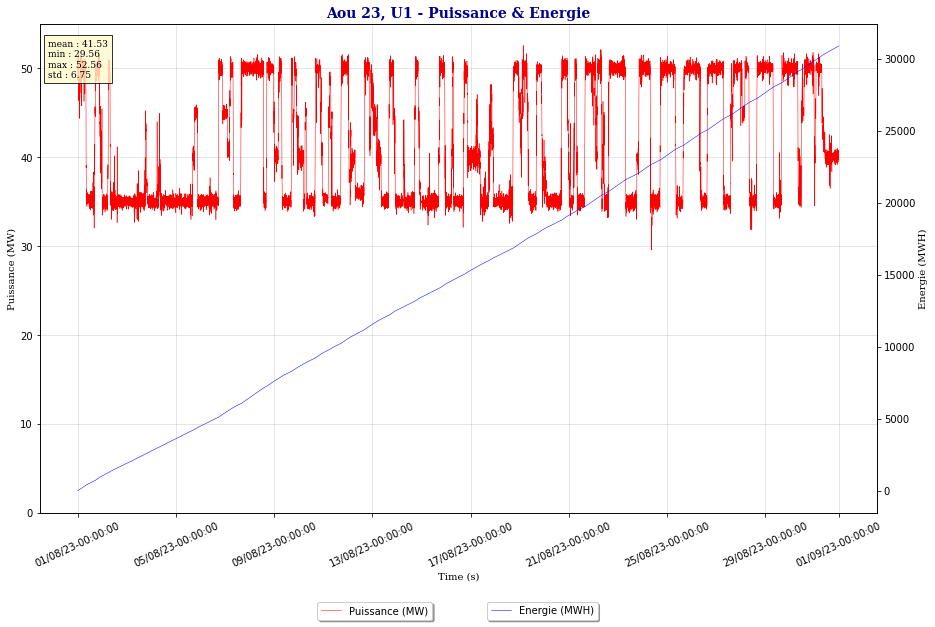

In [34]:
## GRAPHIQUE - Puissance / Energie
TITLE = "{mois} {year}, {TR} - Puissance & Energie".format(mois=MONTH, year=YEAR, TR=TRANCHE) # Titre de la figure
plot_var_y1 = 'U1_PUISSANCE_MW'
plot_var_y2 = 'U1_ENERGIE_MWH_CUM'

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15,9)) # Nombre et disposition des zones de dessin

# Format date xaxis
myFmt = mdates.DateFormatter('%d/%m/%y-%H:%M:%S')
axes.xaxis.set_major_formatter(myFmt)
plt.xticks(rotation=25)

# Texte instructions
text = "mean : {mean:.2f}\nmin : {min:.2f}\nmax : {max:.2f}\nstd : {std:.2f}".format(mean=df_DATA[plot_var_y1].describe()[1],std=df_DATA[plot_var_y1].describe()[2],min=df_DATA[plot_var_y1].describe()[3],max=df_DATA[plot_var_y1].describe()[7])
plt.text(0.01, 0.89, text, transform=axes.transAxes,
         fontdict={'family': 'serif','color' : 'black','weight': 'normal','size': 9},
         bbox = {'facecolor' : 'lemonchiffon', 'alpha' : 0.8})


# Axe 1
axes.set_title(TITLE, fontdict={'family': 'serif','color' : 'darkblue','weight': 'bold','size': 14})
axes.set_xlabel("Time (s)", fontdict={'family': 'serif','color' : 'black','weight': 'light','size': 10})
axes.set_ylabel("Puissance (MW)", fontdict={'family': 'serif','color' : 'black','weight': 'light','size': 10})
axes.plot(df_DATA.U9_TIME,df_DATA.U1_PUISSANCE_MW,'r',linewidth=.5,label="Puissance (MW)")
axes.legend(loc="center",bbox_to_anchor=(0,0,0.8,-0.4), ncol=1, fancybox=True, shadow=True)
axes.set_ylim(0,55)

# Axe 2
axe2 = axes.twinx()
axe2.set_ylabel("Energie (MWH)", fontdict={'family': 'serif','color' : 'black','weight': 'light','size': 10})
axe2.plot(df_DATA.U9_TIME, df_DATA.U1_ENERGIE_MWH_CUM, color = 'b', linewidth=.5, label="Energie (MWH)")
axe2.legend(loc="center",bbox_to_anchor=(0,0,1.2,-0.4), ncol=1, fancybox=True, shadow=True)
# axe2.set_ylim(34.2,34.6)

# Option grille
axes.grid(True,alpha=0.4)

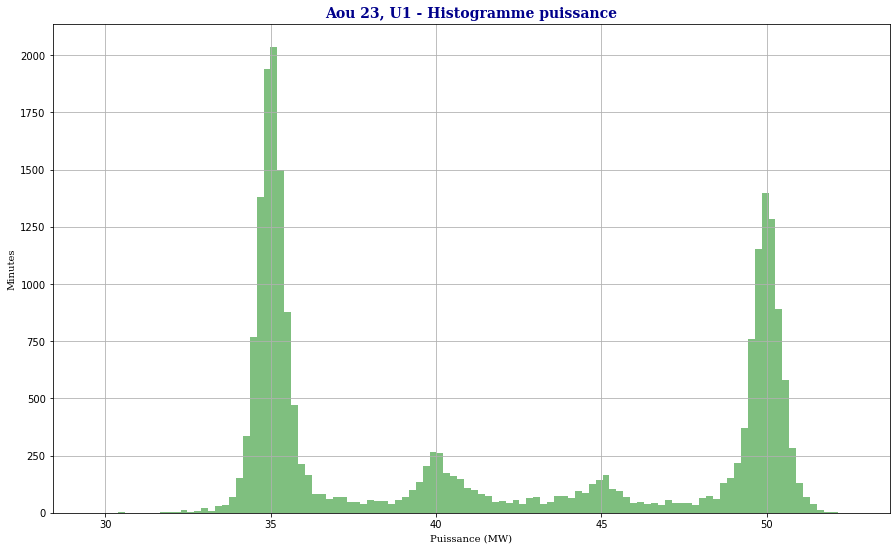

In [35]:
## GRAPHIQUE 2 - Histogramme répartition puissance sur le mois
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15,9))

axes.set_title("{mois} {year}, {TR} - Histogramme puissance".format(mois=MONTH, year=YEAR, TR=TRANCHE), fontdict={'family': 'serif','color' : 'darkblue','weight': 'bold','size': 14})
axes.set_xlabel("Puissance (MW)", fontdict={'family': 'serif','color' : 'black','weight': 'light','size': 10})
axes.set_ylabel("Minutes", fontdict={'family': 'serif','color' : 'black','weight': 'light','size': 10})

num_bins = 110

axes.hist(df_DATA.U1_PUISSANCE_MW,num_bins, color='green',alpha=0.5)
axes.grid(True)

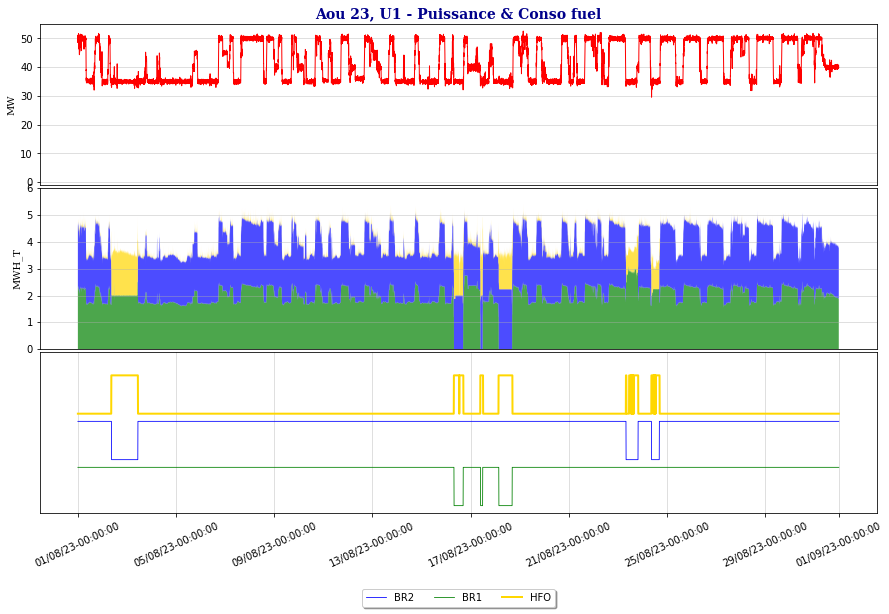

In [39]:
## GRAPHIQUE - Puissance / charbon vs fuel
TITLE = "{mois} {year}, {TR} - Puissance & Conso fuel".format(mois=MONTH, year=YEAR, TR=TRANCHE) # Titre de la figure

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15,9)) # Nombre et disposition des zones de dessin
fig.subplots_adjust(hspace=0.02)

# Format date xaxis
myFmt = mdates.DateFormatter('%d/%m/%y-%H:%M:%S')
axes[2].xaxis.set_major_formatter(myFmt)
plt.xticks(rotation=25)

# Zone 1
axes[0].set_title(TITLE, fontdict={'family': 'serif','color' : 'darkblue','weight': 'bold','size': 14})
axes[0].plot(df_DATA.U9_TIME,df_DATA.U1_PUISSANCE_MW,'r',linewidth=1,label="Puissance U1 (MW)")
axes[0].set_ylabel("MW", fontdict={'family': 'serif','color' : 'black','weight': 'light','size': 10})
axes[0].grid(True, alpha=0.5)
axes[0].xaxis.set_visible(False)
axes[0].set_ylim(-1,55)

# Zone 2
color_map = ["g", "b", "gold"]
axes[1].stackplot(df_DATA.U9_TIME,[df_DATA.U1_BR1_COAL_MWHT, df_DATA.U1_BR2_COAL_MWHT, df_DATA.U1_HFO_COAL_MWHT], colors = color_map, alpha = 0.7)
axes[1].set_ylim(0,6)
axes[1].set_ylabel("MWH_T", fontdict={'family': 'serif','color' : 'black','weight': 'light','size': 10})
axes[1].grid(True, alpha=0.5)
axes[1].xaxis.set_visible(False)

# Zone 3
axes[2].plot(df_DATA.U9_TIME,df_DATA.U1_BOOL_BR2,'b',linewidth=0.8,label="BR2")
axes[2].plot(df_DATA.U9_TIME,df_DATA.U1_BOOL_BR1,'g',linewidth=0.8,label="BR1")
axes[2].plot(df_DATA.U9_TIME,df_DATA.U1_BOOL_HFO,'gold',linewidth=2,label="HFO")
axes[2].set_ylim(-0.1,2)
axes[2].grid(True, alpha=0.5)
axes[2].yaxis.set_visible(False)


# Légende
axes[2].legend(loc="center",bbox_to_anchor=(0,0,1,-1.05), ncol=3, fancybox=True, shadow=True)

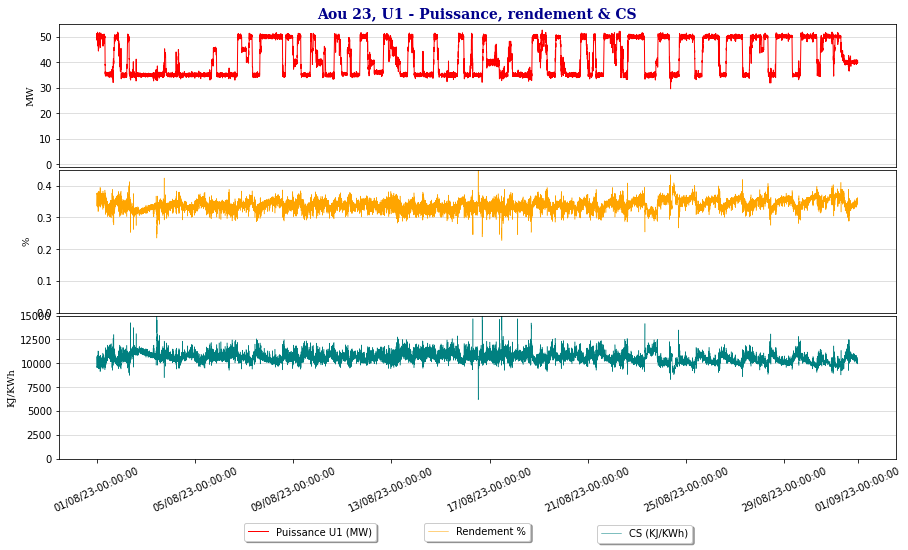

In [41]:
## GRAPHIQUE - Puissance, Rendement, CS
TITLE = "{mois} {year}, {TR} - Puissance, rendement & CS".format(mois=MONTH, year=YEAR, TR=TRANCHE) # Titre de la figure

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15,8)) # Nombre et disposition des zones de dessin
fig.subplots_adjust(hspace=0.02)

# Format date xaxis
myFmt = mdates.DateFormatter('%d/%m/%y-%H:%M:%S')
axes[2].xaxis.set_major_formatter(myFmt)
plt.xticks(rotation=25)

# Zone 1
axes[0].set_title(TITLE, fontdict={'family': 'serif','color' : 'darkblue','weight': 'bold','size': 14})
axes[0].plot(df_DATA.U9_TIME,df_DATA.U1_PUISSANCE_MW,'r',linewidth=1,label="Puissance U1 (MW)")
axes[0].set_ylabel("MW", fontdict={'family': 'serif','color' : 'black','weight': 'light','size': 10})
axes[0].grid(True, alpha=0.5)
axes[0].xaxis.set_visible(False)
axes[0].set_ylim(-1,55)

# Zone 2

axes[1].plot(df_DATA.U9_TIME,df_DATA.U1_RENDEMENT,'orange',linewidth=.5,label="Rendement %")
axes[1].set_ylabel("%", fontdict={'family': 'serif','color' : 'black','weight': 'light','size': 10})
axes[1].xaxis.set_visible(False)
axes[1].grid(True, alpha=0.5)
axes[1].set_ylim(0,0.45) # zoom axe y

# Zone 3
axes[2].plot(df_DATA.U9_TIME,df_DATA.U1_CS,'teal',linewidth=.5,label="CS (KJ/KWh)")
axes[2].set_ylabel("KJ/KWh", fontdict={'family': 'serif','color' : 'black','weight': 'light','size': 10})
axes[2].grid(True, axis = 'y', alpha=0.5)
axes[2].set_ylim(0,15000) # zoom axe y

# Légende
axes[0].legend(loc="center",bbox_to_anchor=(0,0,0.6,-5.1), ncol=1, fancybox=True, shadow=True)
axes[1].legend(loc="center",bbox_to_anchor=(0,0,1,-3.06), ncol=1, fancybox=True, shadow=True)
axes[2].legend(loc="center",bbox_to_anchor=(0,0,1.4,-1.05), ncol=1, fancybox=True, shadow=True)

In [42]:
df_DATA_HFO = df_DATA[df_DATA['U1_BOOL_HFO']==1.7]
df_DATA_BR1 = df_DATA[df_DATA['U1_BOOL_BR1']==0.5]
df_DATA_BR2 = df_DATA[df_DATA['U1_BOOL_BR2']==1.1]

df_DATA_HFO_gb_rendement = df_DATA_HFO.groupby('U1_PUISSANCE_MW').agg({'U1_RENDEMENT':'mean'})
df_DATA_BR1_gb_rendement = df_DATA_BR1.groupby('U1_PUISSANCE_MW').agg({'U1_RENDEMENT':'mean'})
df_DATA_BR2_gb_rendement = df_DATA_BR2.groupby('U1_PUISSANCE_MW').agg({'U1_RENDEMENT':'mean'})

df_DATA_HFO_gb_rendement['U1_MA_HFO'] = df_DATA_HFO_gb_rendement.rolling(window=10).mean()
df_DATA_BR1_gb_rendement['U1_MA_BR1'] = df_DATA_BR1_gb_rendement.rolling(window=10).mean()
df_DATA_BR2_gb_rendement['U1_MA_BR2'] = df_DATA_BR2_gb_rendement.rolling(window=10).mean()

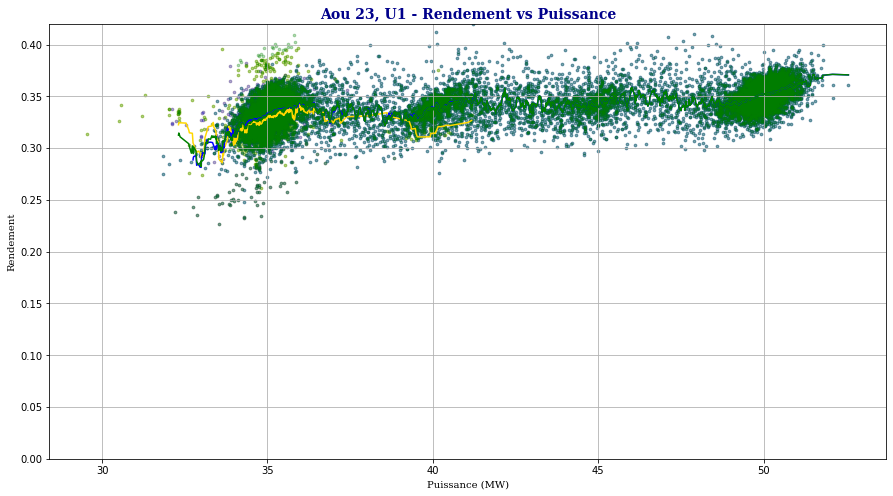

In [44]:
## GRAPHIQUE - Rendement vs Puissance
TITLE = "{mois} {year}, {TR} - Rendement vs Puissance".format(mois=MONTH, year=YEAR, TR=TRANCHE) # Titre de la figure
plot_var_y1 = 'PUISSANCE_MW'

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15,8)) # Nombre et disposition des zones de dessin


# Axe 1
axes.set_title(TITLE, fontdict={'family': 'serif','color' : 'darkblue','weight': 'bold','size': 14})
axes.set_xlabel("Puissance (MW)", fontdict={'family': 'serif','color' : 'black','weight': 'light','size': 10})
axes.set_ylabel("Rendement", fontdict={'family': 'serif','color' : 'black','weight': 'light','size': 10})
axes.scatter(df_DATA_HFO.U1_PUISSANCE_MW, df_DATA_HFO.U1_RENDEMENT,7,color='gold', marker='o',alpha=0.3,label="")
axes.scatter(df_DATA_BR2.U1_PUISSANCE_MW, df_DATA_BR2.U1_RENDEMENT,7,color='b', marker='o',alpha=0.3,label="")
axes.scatter(df_DATA_BR1.U1_PUISSANCE_MW, df_DATA_BR1.U1_RENDEMENT,7,color='g', marker='o',alpha=0.3,label="")

axes.plot(df_DATA_HFO_gb_rendement.index.values,df_DATA_HFO_gb_rendement.U1_MA_HFO,'gold',linewidth=1.5,label="")
axes.plot(df_DATA_BR2_gb_rendement.index.values,df_DATA_BR2_gb_rendement.U1_MA_BR2,'b',linewidth=1.5,label="")
axes.plot(df_DATA_BR1_gb_rendement.index.values,df_DATA_BR1_gb_rendement.U1_MA_BR1,'g',linewidth=1.5,label="")


# axes.legend(loc="center",bbox_to_anchor=(0,0,0.8,-0.4), ncol=1, fancybox=True, shadow=True)
axes.set_ylim(0,0.42)
axes.grid(True)